# Sentiment Classification with neural networks

The aim of the project is to implement a neural network that is able to classify a movie review, into negative or positive. The data used was the IMDB dataset which contains 25,000 reviews. The general idea is to create a base neural networks model and improve it in order to have better results in accuracy and training speed. It is divided in 4 models:

- [**Model 1**: base Neural Network](#model1)
- [**Model 2**: reducing noise in our input data](#model2)
- [**Model 3**: eliminating unnecessary matrix multiplications](#model3)
- [**Model 4**: reducing unnecessary vocabulary](#model4)
- [**Analysis**: what's going on in the Weights?](#weights)

Data: IMDB movie reviews

# Dataset

In [1]:
import numpy as np
from collections import Counter
import time
import sys

In [2]:
def pretty_print_review_and_label(i):
    print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('data/reviews.txt','r') 
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('data/labels.txt','r') 
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

**Note:** The data in `reviews.txt` we're using has already been preprocessed a bit and contains only lower case characters. If we were working from raw data, where we didn't know it was all lower case, we would want to add a step here to convert it. That's so we treat different variations of the same word, like `The`, `the`, and `THE`, all the same way.

In [3]:
len(reviews)

25000

In [4]:
print(reviews[0])
print(' ')
print(labels[0])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
 
POSITIVE


### print some reviews

In [5]:
print("labels.txt \t : \t reviews.txt\n")
pretty_print_review_and_label(0)
pretty_print_review_and_label(12816)
pretty_print_review_and_label(6267)
pretty_print_review_and_label(21934)
pretty_print_review_and_label(5297)
pretty_print_review_and_label(24999)

labels.txt 	 : 	 reviews.txt

POSITIVE	:	bromwell high is a cartoon comedy . it ran at the same time as some other progra...
POSITIVE	:	adrian pasdar is excellent is this film . he makes a fascinating woman .  ...
NEGATIVE	:	comment this movie is impossible . is terrible  very improbable  bad interpretat...
POSITIVE	:	excellent episode movie ala pulp fiction .  days   suicides . it doesnt get more...
NEGATIVE	:	if you haven  t seen this  it  s terrible . it is pure trash . i saw this about ...
NEGATIVE	:	this is one of the dumbest films  i  ve ever seen . it rips off nearly ever type...


# Quick Theory Validation

In [6]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    if(labels[i] == 'POSITIVE'):
        for word in reviews[i].split(" "):
            positive_counts[word] += 1
            total_counts[word] += 1
    else:
        for word in reviews[i].split(" "):
            negative_counts[word] += 1
            total_counts[word] += 1

In [7]:
# Examine the counts of the 10 most common words in positive reviews
positive_counts.most_common(10)

[('', 550468),
 ('the', 173324),
 ('.', 159654),
 ('and', 89722),
 ('a', 83688),
 ('of', 76855),
 ('to', 66746),
 ('is', 57245),
 ('in', 50215),
 ('br', 49235)]

In [8]:
# Examine the counts of the 10 most common words in negative reviews
negative_counts.most_common(10)

[('', 561462),
 ('.', 167538),
 ('the', 163389),
 ('a', 79321),
 ('and', 74385),
 ('of', 69009),
 ('to', 68974),
 ('br', 52637),
 ('is', 50083),
 ('it', 48327)]

As you can see, common words like "the" appear very often in both positive and negative reviews. Instead of finding the most common words in positive or negative reviews, what you really want are the words found in positive reviews more often than in negative reviews, and vice versa. To accomplish this, it will be necessary to calculate the ratios of word usage between positive and negative reviews.

In [9]:
pos_neg_ratios = Counter()

for word, count in list(total_counts.most_common()):
    if(count > 100):
        pos_neg_ratio = positive_counts[word] / float(negative_counts[word]+1)
        pos_neg_ratios[word] = pos_neg_ratio

In [10]:
pos_neg_ratios.most_common(10)

[('edie', 109.0),
 ('paulie', 59.0),
 ('felix', 23.4),
 ('polanski', 16.833333333333332),
 ('matthau', 16.555555555555557),
 ('victoria', 14.6),
 ('mildred', 13.5),
 ('gandhi', 12.666666666666666),
 ('flawless', 11.6),
 ('superbly', 9.583333333333334)]

Examine the ratios:

In [11]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 1.0607993145235326
Pos-to-neg ratio for 'amazing' = 4.022813688212928
Pos-to-neg ratio for 'terrible' = 0.17744252873563218


Transforming ratios to logarithms to have a better understanding of them.

In [12]:
# Convert ratios to logs
for word, ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

In [13]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 0.05902269426102881
Pos-to-neg ratio for 'amazing' = 1.3919815802404802
Pos-to-neg ratio for 'terrible' = -1.7291085042663878


# Transforming text into numbers

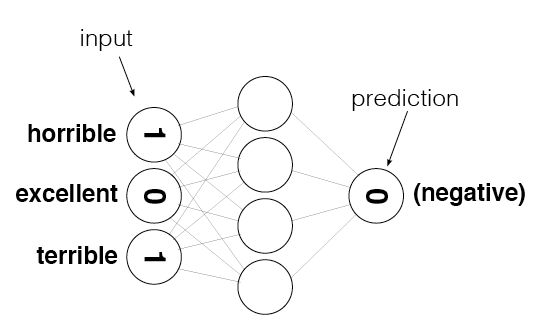

In [14]:
from IPython.display import Image

review = "This was a horrible, terrible movie."

Image(filename='assets/sentiment_network.png')

In [15]:
# all words
review_vocab = set(total_counts)
review_vocab_size = len(review_vocab)
print('All difeents words in reviews:', review_vocab_size)

# input layer
layer_0 = np.zeros((1,review_vocab_size))
print('Input layer shape:', layer_0.shape)

# indexing words
index2word = dict(enumerate(review_vocab))
word2index = {word: i for i, word in index2word.items()}

# reset the layer to be all 0s
def update_input_layer(review):
    
    global layer_0
    # reset the layer to be all 0s
    layer_0 *= 0
    
    # count how many times each word is used in the given review and store the results in layer_0 
    for word in review.split(" "):
        layer_0[0][word2index[word]] += 1

# Convert a label to 0 or `1        
def get_target_for_label(label):
    if label == 'POSITIVE':
        return 1
    else:
        return 0

All difeents words in reviews: 74074
Input layer shape: (1, 74074)


In [16]:
update_input_layer(reviews[0])
layer_0

array([[18.,  0.,  0., ...,  0.,  0.,  0.]])

# Model 1: Base Neural Network <a id='model1'></a>

In [17]:
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        
        np.random.seed(0)
        
        self.pre_process_data(reviews, labels)
        
        self.init_network(self.review_vocab_size, hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews, labels):
        
        # words in all reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
                
        self.review_vocab = review_vocab
        
        # size of all words
        self.review_vocab_size = len(self.review_vocab)

        # word2index dictionary
        index2word = dict(enumerate(self.review_vocab))
        self.word2index = {word: i for i, word in index2word.items()}
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes   
        
        self.learning_rate = learning_rate
        
       # weights between the input layer and the hidden layer
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))
    
        # weights between the hidden layer and the output layer
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # input layer, two-dimensional matrix
        self.layer_0 = np.zeros((1, input_nodes))
        
    def update_input_layer(self, review):
            
        # reset the layer to be all 0s 
        self.layer_0 *= 0
        
        # if fixs the reprogram error
        for word in review.split(" "):
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] += 1
    
    def get_target_for_label(self, label):   
        if label == 'POSITIVE':
            return 1
        else:
            return 0
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_prime(self, output):
        return output * (1 - output)
    
    def train(self, training_reviews, training_labels):
        
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # correct predictions  
        correct_so_far = 0
        
        start = time.time()
        
        for i in range(len(training_reviews)):
            
            review = training_reviews[i]
            label = training_labels[i]
            
            self.update_input_layer(review)
            
            # fordward pass
            layer_1 = np.matmul(self.layer_0, self.weights_0_1)
            layer_2 = self.sigmoid(np.matmul(layer_1, self.weights_1_2))
            
            # output error
            layer_2_error = self.get_target_for_label(label) - layer_2
            delta_layer_2 = layer_2_error * self.sigmoid_prime(layer_2)
            
            # hidden error  
            layer_1_error = delta_layer_2 * self.weights_1_2
            delta_layer_1 = layer_1_error 
            
           # update the weights
            self.weights_1_2 += self.learning_rate * delta_layer_2 * layer_1.T
            self.weights_0_1 += self.learning_rate * np.transpose(delta_layer_1 * self.layer_0)
            
            # keep track of correct predictions    
            if layer_2 >= 0.5 and label == 'POSITIVE':
                correct_so_far += 1
            elif layer_2 < 0.5 and label == 'NEGATIVE':
                correct_so_far += 1
            
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
        
    def run(self, review):
        
        # inputs
        self.update_input_layer(review)
        
        # fordward pass
        layer_1 = np.matmul(self.layer_0, self.weights_0_1)
        layer_2 = self.sigmoid(np.matmul(layer_1, self.weights_1_2))
        
    
        if layer_2[0] >= 0.5:
            return 'POSITIVE'
        else:
            return 'NEGATIVE'
    
    def test(self, test_reviews, test_labels):
        
        correct = 0
        
        start = time.time()
        
        for i in range(len(test_reviews)):
            pred = self.run(test_reviews[i])
            if(pred == test_labels[i]):
                correct += 1
                
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0   
                
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(test_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")

### Training neural network

**learning rate = 0.1**

In [18]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000])
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):134.1 #Correct:1210 #Trained:2501 Training Accuracy:48.3%
Progress:20.8% Speed(reviews/sec):134.5 #Correct:2518 #Trained:5001 Training Accuracy:50.3%
Progress:31.2% Speed(reviews/sec):133.3 #Correct:3849 #Trained:7501 Training Accuracy:51.3%
Progress:41.6% Speed(reviews/sec):133.2 #Correct:5395 #Trained:10001 Training Accuracy:53.9%
Progress:52.0% Speed(reviews/sec):134.0 #Correct:6910 #Trained:12501 Training Accuracy:55.2%
Progress:62.5% Speed(reviews/sec):134.6 #Correct:8454 #Trained:15001 Training Accuracy:56.3%
Progress:72.9% Speed(reviews/sec):134.5 #Correct:10014 #Trained:17501 Training Accuracy:57.2%
Progress:83.3% Speed(reviews/sec):134.2 #Correct:11641 #Trained:20001 Training Accuracy:58.2%
Progress:93.7% Speed(reviews/sec):133.9 #Correct:13264 #Trained:22501 Training Accuracy:58.9%
Progress:99.9% Speed(reviews/sec):134.1 #Correct:14326 #Trained:24000 Training A

Accuracy don't change so we'll increase the learning rate.

**learning rate = 0.001**


In [19]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.001)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):133.9 #Correct:1354 #Trained:2501 Training Accuracy:54.1%
Progress:20.8% Speed(reviews/sec):134.8 #Correct:2903 #Trained:5001 Training Accuracy:58.0%
Progress:31.2% Speed(reviews/sec):133.8 #Correct:4564 #Trained:7501 Training Accuracy:60.8%
Progress:41.6% Speed(reviews/sec):132.9 #Correct:6310 #Trained:10001 Training Accuracy:63.0%
Progress:52.0% Speed(reviews/sec):133.0 #Correct:8107 #Trained:12501 Training Accuracy:64.8%
Progress:62.5% Speed(reviews/sec):131.6 #Correct:9909 #Trained:15001 Training Accuracy:66.0%
Progress:72.9% Speed(reviews/sec):131.1 #Correct:11700 #Trained:17501 Training Accuracy:66.8%
Progress:83.3% Speed(reviews/sec):131.4 #Correct:13573 #Trained:20001 Training Accuracy:67.8%
Progress:93.7% Speed(reviews/sec):131.0 #Correct:15442 #Trained:22501 Training Accuracy:68.6%
Progress:99.9% Speed(reviews/sec):131.4 #Correct:16597 #Trained:24000 Training A

### Testing neural network

In [20]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:17.3% Speed(reviews/sec):1044. #Correct:138 #Tested:174 Testing Accuracy:79.3%

Progress:99.9% Speed(reviews/sec):1096. #Correct:747 #Tested:1000 Testing Accuracy:74.7%

# Model 2: reducing noise in our input data <a id='model2'></a>

Modify `update_input_layer` so it does not count how many times each word is used, but rather just stores whether or not a word was used. This is done to prevent tokens like '.' or blank spaces from dominating the training.

In [21]:
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        
        np.random.seed(0)
        
        self.pre_process_data(reviews, labels)
        
        self.init_network(self.review_vocab_size, hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews, labels):
        
        # words in all reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
                
        self.review_vocab = review_vocab
        
        # size of all words
        self.review_vocab_size = len(self.review_vocab)

        # word2index dictionary
        index2word = dict(enumerate(review_vocab))
        self.word2index = {word: i for i, word in index2word.items()}
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes   
        
        self.learning_rate = learning_rate
        
       # weights between the input layer and the hidden layer
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))
    
        # weights between the hidden layer and the output layer
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # input layer, two-dimensional matrix
        self.layer_0 = np.zeros((1, input_nodes))
        
    def update_input_layer(self, review):
            
        # reset the layer to be all 0s 
        self.layer_0 *= 0
        
        # if fixs the reprogram error
        for word in review.split(" "):
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] = 1
    
    def get_target_for_label(self, label):   
        if label == 'POSITIVE':
            return 1
        else:
            return 0
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_prime(self, output):
        return output * (1 - output)
    
    def train(self, training_reviews, training_labels):
        
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # correct predictions  
        correct_so_far = 0
        
        start = time.time()
        
        for i in range(len(training_reviews)):
            
            review = training_reviews[i]
            label = training_labels[i]
            
            self.update_input_layer(review)
            
            # fordward pass
            layer_1 = np.matmul(self.layer_0, self.weights_0_1)
            layer_2 = self.sigmoid(np.matmul(layer_1, self.weights_1_2))
            
            # output error
            layer_2_error = self.get_target_for_label(label) - layer_2
            delta_layer_2 = layer_2_error * self.sigmoid_prime(layer_2)
            
            # hidden error  
            layer_1_error = delta_layer_2 * self.weights_1_2
            delta_layer_1 = layer_1_error 
            
           # update the weights
            self.weights_1_2 += self.learning_rate * delta_layer_2 * layer_1.T
            self.weights_0_1 += self.learning_rate * np.transpose(delta_layer_1 * self.layer_0)
            
            # keep track of correct predictions    
            if layer_2 >= 0.5 and label == 'POSITIVE':
                correct_so_far += 1
            elif layer_2 < 0.5 and label == 'NEGATIVE':
                correct_so_far += 1
            
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
        
    def run(self, review):
        
        # inputs
        self.update_input_layer(review)
        
        # fordward pass
        layer_1 = np.matmul(self.layer_0, self.weights_0_1)
        layer_2 = self.sigmoid(np.matmul(layer_1, self.weights_1_2))
        
    
        if layer_2[0] >= 0.5:
            return 'POSITIVE'
        else:
            return 'NEGATIVE'
    
    def test(self, test_reviews, test_labels):
        
        correct = 0
        
        start = time.time()
        
        for i in range(len(test_reviews)):
            pred = self.run(test_reviews[i])
            if(pred == test_labels[i]):
                correct += 1
                
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0   
                
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(test_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")

### Training neural network

In [22]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000])
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):140.9 #Correct:1948 #Trained:2501 Training Accuracy:77.8%
Progress:20.8% Speed(reviews/sec):140.1 #Correct:3994 #Trained:5001 Training Accuracy:79.8%
Progress:31.2% Speed(reviews/sec):139.9 #Correct:6121 #Trained:7501 Training Accuracy:81.6%
Progress:41.6% Speed(reviews/sec):137.1 #Correct:8280 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):136.5 #Correct:10441 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):136.1 #Correct:12583 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):134.9 #Correct:14697 #Trained:17501 Training Accuracy:83.9%
Progress:83.3% Speed(reviews/sec):135.4 #Correct:16871 #Trained:20001 Training Accuracy:84.3%
Progress:93.7% Speed(reviews/sec):134.3 #Correct:19058 #Trained:22501 Training Accuracy:84.6%
Progress:99.9% Speed(reviews/sec):134.6 #Correct:20378 #Trained:24000 Training A

### Testing neural network

In [23]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):1186. #Correct:860 #Tested:1000 Testing Accuracy:86.0%

# Model 3: eliminating unnecessary matrix multiplications <a id='model3'></a>

The output of the hidden layer is a huge matrix, most of these values are zeros because of the initial input. This is really computationally inefficient, so we will change the model by eliminating unnecessary multiplications and additions that occur during forward and backward propagation.

In [24]:
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        
        np.random.seed(0)
        
        self.pre_process_data(reviews, labels)
        
        self.init_network(self.review_vocab_size, hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews, labels):
        
        # words in all reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)
                
        self.review_vocab = review_vocab
        
        # size of all words
        self.review_vocab_size = len(self.review_vocab)

        # word2index dictionary
        index2word = dict(enumerate(review_vocab))
        self.word2index = {word: i for i, word in index2word.items()}
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes   
        
        self.learning_rate = learning_rate
        
       # weights between the input layer and the hidden layer
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))
    
        # weights between the hidden layer and the output layer
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # layer_1 (NEW)
        self.layer_1 = np.zeros((1, hidden_nodes))
    
    def get_target_for_label(self, label):   
        if label == 'POSITIVE':
            return 1
        else:
            return 0
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_prime(self, output):
        return output * (1 - output)
    
    def train(self, training_reviews_raw, training_labels):
        
        # big list: in each row there is a list of the indexes 
        # corresponding to each word used in each review (NEW)
        training_reviews = []
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(' '):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
            
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # correct predictions 
        correct_so_far = 0
        
        start = time.time()
            
        for i in range(len(training_reviews)):
            
            review = training_reviews[i] # training_reviews is a list
            label = training_labels[i]
                        
            # fordward pass
            # (NEW)
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]
                
            layer_2 = self.sigmoid(np.matmul(self.layer_1, self.weights_1_2))

            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_prime(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate
            
            # keep track of correct predictions    
            if layer_2 >= 0.5 and label == 'POSITIVE':
                correct_so_far += 1
            elif layer_2 < 0.5 and label == 'NEGATIVE':
                correct_so_far += 1
            
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")    
    
    def run(self, review):

        # fordward pass (NEW)
        self.layer_1 *= 0
        indices = set()
        for word in review.split(' '):
            if word in self.word2index.keys():
                indices.add(self.word2index[word])
                
        # update layer_1 only with weights[indices] (NEW)        
        for index in indices:
            self.layer_1 += self.weights_0_1[index]
        
        layer_2 = self.sigmoid(np.matmul(self.layer_1, self.weights_1_2))
    
        if layer_2[0] >= 0.5:
            return 'POSITIVE'
        else:
            return 'NEGATIVE'
    
    def test(self, test_reviews, test_labels):
        
        correct = 0
        
        start = time.time()
        
        for i in range(len(test_reviews)):
            pred = self.run(test_reviews[i])
            if(pred == test_labels[i]):
                correct += 1
                
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0   
                
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(test_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")

In [25]:
mlp = SentimentNetwork(reviews[:-1000], labels[:-1000], learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1724. #Correct:1948 #Trained:2501 Training Accuracy:77.8%
Progress:20.8% Speed(reviews/sec):1681. #Correct:3994 #Trained:5001 Training Accuracy:79.8%
Progress:31.2% Speed(reviews/sec):1603. #Correct:6121 #Trained:7501 Training Accuracy:81.6%
Progress:41.6% Speed(reviews/sec):1610. #Correct:8280 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):1590. #Correct:10441 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):1583. #Correct:12583 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):1574. #Correct:14697 #Trained:17501 Training Accuracy:83.9%
Progress:83.3% Speed(reviews/sec):1577. #Correct:16871 #Trained:20001 Training Accuracy:84.3%
Progress:93.7% Speed(reviews/sec):1580. #Correct:19058 #Trained:22501 Training Accuracy:84.6%
Progress:99.9% Speed(reviews/sec):1574. #Correct:20378 #Trained:24000 Training A

In [26]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:68.5% Speed(reviews/sec):2470. #Correct:596 #Tested:686 Testing Accuracy:86.8%

Progress:99.9% Speed(reviews/sec):2504. #Correct:860 #Tested:1000 Testing Accuracy:86.0%

# Model 4: reducing unnecessary vocabulary <a id='model4'></a>

We have tons of words in our corpus that don't have predictive power, words as ``the`` or blank spaces, so lets get rid of them.

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Visualize

In [28]:
pos_neg_ratios.most_common(5)

[('edie', 4.6913478822291435),
 ('paulie', 4.07753744390572),
 ('felix', 3.152736022363656),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.80672172860924)]

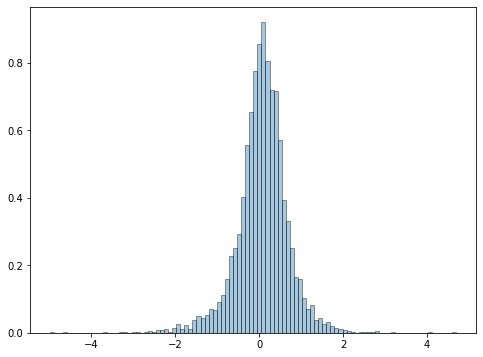

In [29]:
ratios = list(map(lambda x:x[1], pos_neg_ratios.most_common()))

fig = plt.figure(figsize=(8, 6))
sns.distplot(ratios, bins=100, hist_kws=dict(edgecolor="k"), kde=False, norm_hist=True)
plt.show()

The words in which pos_neg_ratio is closest to zero are irrelevant.

In [30]:
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1, min_count = 50, polarity_cutoff = 0.1):
        
        np.random.seed(0)
        
        self.pre_process_data(reviews, labels, min_count, polarity_cutoff)
        
        self.init_network(self.review_vocab_size, hidden_nodes, 1, learning_rate)
        
    def pre_process_data(self, reviews, labels, min_count, polarity_cutoff):
        
        #-------new for model 4
        
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()
        
        # counters words
        for i in range(len(reviews)):
            if labels[i] == 'POSITIVE':
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1
        
        pos_neg_ratios = Counter()
        
        # pos_neg_ratio
        for word, count in list(total_counts.most_common()):
            if count > min_count:
                pos_neg_ratio = positive_counts[word] / float(negative_counts[word]+1)
                pos_neg_ratios[word] = pos_neg_ratio
                
        #log(pos_neg_ratios)
        for word, ratio in pos_neg_ratios.most_common():
            if ratio > 1:
                pos_neg_ratios[word] = np.log(ratio)
                
            # to avoid RuntimeWarning: divide by zero encountered in log
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        
        #-------
        
        # words in all reviews 
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                if total_counts[word] > min_count: # NEW for model 4
                    if word in pos_neg_ratios.keys():
                        if pos_neg_ratios[word] >= polarity_cutoff or pos_neg_ratios[word] <= -polarity_cutoff:
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)
                                                       
        self.review_vocab = review_vocab
        
        # size of all words
        self.review_vocab_size = len(self.review_vocab)

        # word2index dictionary
        index2word = dict(enumerate(review_vocab))
        self.word2index = {word: i for i, word in index2word.items()}
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes   
        
        self.learning_rate = learning_rate
        
       # weights between the input layer and the hidden layer
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
    
        # weights between the hidden layer and the output layer
        self.weights_1_2 = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # layer_1 (NEW)
        self.layer_1 = np.zeros((1, hidden_nodes))
    
    def get_target_for_label(self, label):   
        if label == 'POSITIVE':
            return 1
        else:
            return 0
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_prime(self, output):
        return output * (1 - output)
    
    def train(self, training_reviews_raw, training_labels):
        
        # big list: in each row there is a list of the indexes 
        # corresponding to each word used in each review (NEW)
        training_reviews = []
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(' '):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
            
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # correct predictions 
        correct_so_far = 0
        
        start = time.time()
            
        for i in range(len(training_reviews)):
            
            review = training_reviews[i] # training_reviews is a list
            label = training_labels[i]
                        
            # fordward pass
            # (NEW)
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]
                
            layer_2 = self.sigmoid(np.matmul(self.layer_1, self.weights_1_2))

            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_prime(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate
            
            # keep track of correct predictions    
            if layer_2 >= 0.5 and label == 'POSITIVE':
                correct_so_far += 1
            elif layer_2 < 0.5 and label == 'NEGATIVE':
                correct_so_far += 1
            
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")    
    
    def run(self, review):
        
        # fordward pass (NEW)
        self.layer_1 *= 0
        indices = set()
        for word in review.split(' '):
            if word in self.word2index.keys():
                indices.add(self.word2index[word])
                
        # update layer_1 only with weights[indices] (NEW)        
        for index in indices:
            self.layer_1 += self.weights_0_1[index]
        
        layer_2 = self.sigmoid(np.matmul(self.layer_1, self.weights_1_2))
    
        if layer_2[0] >= 0.5:
            return 'POSITIVE'
        else:
            return 'NEGATIVE'
    
    def test(self, test_reviews, test_labels):
        
        correct = 0
        
        start = time.time()
        
        for i in range(len(test_reviews)):
            pred = self.run(test_reviews[i])
            if(pred == test_labels[i]):
                correct += 1
                
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0   
                
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(test_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")

### polarity_cutoff = 0.05

In [31]:
mlp = SentimentNetwork(reviews[:-1000], labels[:-1000], min_count=50, polarity_cutoff=0.05, learning_rate=0.01)
mlp.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):2053. #Correct:1963 #Trained:2501 Training Accuracy:78.4%
Progress:20.8% Speed(reviews/sec):2052. #Correct:4025 #Trained:5001 Training Accuracy:80.4%
Progress:31.2% Speed(reviews/sec):2067. #Correct:6142 #Trained:7501 Training Accuracy:81.8%
Progress:41.6% Speed(reviews/sec):2057. #Correct:8293 #Trained:10001 Training Accuracy:82.9%
Progress:52.0% Speed(reviews/sec):2054. #Correct:10446 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):2024. #Correct:12571 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):2022. #Correct:14712 #Trained:17501 Training Accuracy:84.0%
Progress:83.3% Speed(reviews/sec):2009. #Correct:16900 #Trained:20001 Training Accuracy:84.4%
Progress:93.7% Speed(reviews/sec):1989. #Correct:19090 #Trained:22501 Training Accuracy:84.8%
Progress:99.9% Speed(reviews/sec):1991. #Correct:20415 #Trained:24000 Training A

In [32]:
mlp.test(reviews[-1000:], labels[-1000:])

Progress:30.8% Speed(reviews/sec):4302. #Correct:272 #Tested:309 Testing Accuracy:88.0%

Progress:80.6% Speed(reviews/sec):3483. #Correct:686 #Tested:807 Testing Accuracy:85.0%

Progress:99.9% Speed(reviews/sec):3514. #Correct:851 #Tested:1000 Testing Accuracy:85.1%

### polarity_cutoff = 0.8

In [33]:
mlp = SentimentNetwork(reviews[:-1000], labels[:-1000], min_count=50, polarity_cutoff=0.8, learning_rate=0.01)
mlp.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):6701. #Correct:2046 #Trained:2501 Training Accuracy:81.8%
Progress:20.8% Speed(reviews/sec):7014. #Correct:4082 #Trained:5001 Training Accuracy:81.6%
Progress:31.2% Speed(reviews/sec):7245. #Correct:6137 #Trained:7501 Training Accuracy:81.8%
Progress:41.6% Speed(reviews/sec):7206. #Correct:8233 #Trained:10001 Training Accuracy:82.3%
Progress:52.0% Speed(reviews/sec):7288. #Correct:10332 #Trained:12501 Training Accuracy:82.6%
Progress:62.5% Speed(reviews/sec):7241. #Correct:12438 #Trained:15001 Training Accuracy:82.9%
Progress:72.9% Speed(reviews/sec):7019. #Correct:14535 #Trained:17501 Training Accuracy:83.0%
Progress:83.3% Speed(reviews/sec):6870. #Correct:16684 #Trained:20001 Training Accuracy:83.4%
Progress:93.7% Speed(reviews/sec):6941. #Correct:18835 #Trained:22501 Training Accuracy:83.7%
Progress:99.9% Speed(reviews/sec):6909. #Correct:20105 #Trained:24000 Training A

The train accuracy decreases to 85% to 83.7% but this model is more than three times faster. Now, we test our model:

In [34]:
mlp.test(reviews[-1000:], labels[-1000:])

Progress:58.3% Speed(reviews/sec):6425. #Correct:505 #Tested:584 Testing Accuracy:86.4%

Progress:99.9% Speed(reviews/sec):6547. #Correct:829 #Tested:1000 Testing Accuracy:82.9%

The test accuracy decreases to 85.1% to 82.9%.

# Analysis: What's Going on in the Weights? <a id='weights'></a>

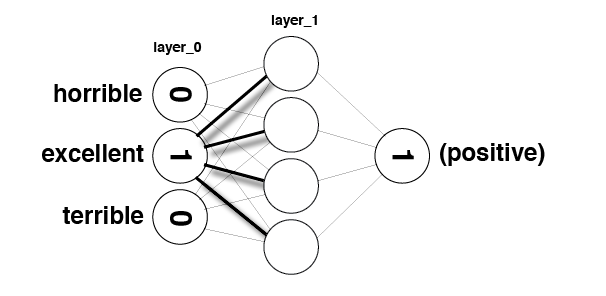

In [35]:
Image(filename='assets/sentiment_network_sparse.png')

In [36]:
mlp_full = SentimentNetwork(reviews[:-1000], labels[:-1000], min_count=0, polarity_cutoff=0, learning_rate=0.01)
mlp_full.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1450. #Correct:1949 #Trained:2501 Training Accuracy:77.9%
Progress:20.8% Speed(reviews/sec):1526. #Correct:4010 #Trained:5001 Training Accuracy:80.1%
Progress:31.2% Speed(reviews/sec):1523. #Correct:6128 #Trained:7501 Training Accuracy:81.6%
Progress:41.6% Speed(reviews/sec):1554. #Correct:8282 #Trained:10001 Training Accuracy:82.8%
Progress:52.0% Speed(reviews/sec):1563. #Correct:10443 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):1575. #Correct:12564 #Trained:15001 Training Accuracy:83.7%
Progress:72.9% Speed(reviews/sec):1583. #Correct:14689 #Trained:17501 Training Accuracy:83.9%
Progress:83.3% Speed(reviews/sec):1558. #Correct:16880 #Trained:20001 Training Accuracy:84.3%
Progress:93.7% Speed(reviews/sec):1553. #Correct:19061 #Trained:22501 Training Accuracy:84.7%
Progress:99.9% Speed(reviews/sec):1547. #Correct:20385 #Trained:24000 Training

### weights of some words

In [37]:
word = 'excellent'
mlp_full.weights_0_1[mlp_full.word2index[word]]

array([ 0.17553329,  0.03981793,  0.09739002,  0.22298168,  0.1858327 ,
       -0.09724474,  0.09453923, -0.01506091, -0.01027087,  0.0408569 ])

In [38]:
word = 'perfect'
mlp_full.weights_0_1[mlp_full.word2index[word]]

array([ 0.15007454,  0.03404287,  0.0832649 ,  0.19064117,  0.15888015,
       -0.08314069,  0.08082758, -0.01287652, -0.00878121,  0.03493115])

In [39]:
word = 'terrible'
mlp_full.weights_0_1[mlp_full.word2index[word]]

array([-0.14294102, -0.03242471, -0.07930706, -0.18157939, -0.15132807,
        0.07918875, -0.07698559,  0.01226446,  0.00836382, -0.03327076])

In [40]:
word = 'horrible'
mlp_full.weights_0_1[mlp_full.word2index[word]]

array([-0.09862662, -0.02237244, -0.05472038, -0.12528638, -0.10441353,
        0.05463875, -0.05311861,  0.00846225,  0.00577088, -0.0229562 ])

We can see that the weights of *excellent* and *perfect* are very similar, just as with and *terrible* and *horrible*. We'll measure this similarity with the next function:

In [41]:
def get_most_similar_words(focus = 'horrible'):
    most_similar = Counter()

    for word in mlp_full.word2index.keys():
        most_similar[word] = np.dot(mlp_full.weights_0_1[mlp_full.word2index[word]], mlp_full.weights_0_1[mlp_full.word2index[focus]])
    
    return most_similar.most_common()

In [42]:
(get_most_similar_words('terrible'))[:10]

[('worst', 0.176111090051414),
 ('awful', 0.12573897452761632),
 ('waste', 0.11991594696209587),
 ('poor', 0.10177489562518097),
 ('boring', 0.09733221548914497),
 ('terrible', 0.09716931878598246),
 ('bad', 0.08172674417406611),
 ('dull', 0.0813654896446496),
 ('worse', 0.0750572518887535),
 ('poorly', 0.07500211598302947)]

In [43]:
(get_most_similar_words('excellent'))[:10]

[('excellent', 0.14653265500918625),
 ('perfect', 0.12528005319898905),
 ('great', 0.10689240585786122),
 ('amazing', 0.10167062600257376),
 ('wonderful', 0.09700602795678442),
 ('best', 0.09619815782059189),
 ('today', 0.09061783739508097),
 ('fun', 0.08856305112471802),
 ('loved', 0.07905252412360383),
 ('definitely', 0.07690017322838016)]

### Visualize

In [44]:
# 1000 words to plot
words_to_visualize = []
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[:500]:
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
        
# get weights for the 1000 words
weights_vector = []
for word in words_to_visualize:
    weights_vector.append(mlp_full.weights_0_1[mlp_full.word2index[word]])
    
# for use hue in seaborn
target = ['positive']*500 + ['negative']*500

In [45]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_tsne = tsne.fit_transform(weights_vector)

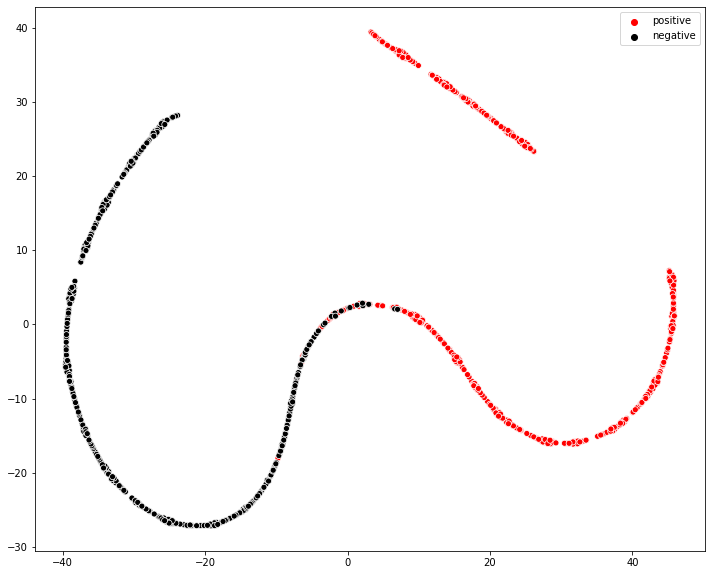

In [46]:
fig = plt.figure(figsize=(12, 10))
sns.scatterplot(x=words_tsne[:,0], y=words_tsne[:,1], hue=target, legend="full", palette=['r', 'k'])
plt.show()

There is a big long negative cluster and two positive clusters. All words have grouped by the value of weights, which have been reduced in two dimensions.